In [ ]:
!pip -q install "rapids-cu11[cuml]" --extra-index-url=https://pypi.nvidia.com

ERROR: Could not find a version that satisfies the requirement rapids-cu11[cuml] (from versions: none)
ERROR: No matching distribution found for rapids-cu11[cuml]


In [66]:
import pandas as pd

In [67]:
col_df = pd.read_csv('/content/drive/MyDrive/Courses/Big_Data/project/data/collisions_ts.csv')

In [68]:
tr_df = pd.read_csv('/content/drive/MyDrive/Courses/Big_Data/project/data/traffic_speeds.csv')

In [69]:
tr_df.shape

(1040366, 5)

In [70]:
col_df = col_df[col_df['timestamp'].str[:7] == '2024-01']
col_df['crash_score'] = (
    col_df['injured'].astype(int) +        # 1 point per injury
    3 * col_df['killed'].astype(int)       # 3 points per fatality
)

# 3. keep only the columns you need
col_df = col_df[['timestamp', 'lat', 'lon', 'crash_score']]

# 4. drop rows with any missing values and reset the index
col_df = col_df.dropna().reset_index(drop=True)

# 5. round each timestamp down to the hour (string slice + append “:00:00”)
col_df['timestamp'] = col_df['timestamp'].str.split(':').str[0] + ':00:00'
#            ↑ keeps “YYYY‑MM‑DD HH”; appends minutes/seconds as 00:00

# 6. convert the timestamp column to Pandas datetime
col_df['timestamp'] = pd.to_datetime(col_df['timestamp'], errors='coerce')


<ipython-input-70-a8207d8e1bac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_df['crash_score'] = (


In [71]:
col_df.shape

(7079, 4)

In [72]:
col_df.min()

,0
timestamp,2024-01-01 00:00:00
lat,0.0
lon,-74.24806
crash_score,0


In [73]:
col_df.max()

,0
timestamp,2024-01-31 23:00:00
lat,40.912468
lon,0.0
crash_score,11


In [74]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# helpers
# ---------------------------------------------------------------------
def compute_centroid(link_points_str: str):
    """
    link_points_str example:
    "-73.98,40.75 -73.99,40.76 -73.97,40.77"
    (lon,lat pairs separated by spaces)
    """
    try:
        pts = [tuple(map(float, p.split(',')))          # → (lon, lat)
               for p in link_points_str.strip().split()]
        if not pts:
            return None, None
        lons, lats = zip(*pts)                          # lon first in string
        return np.mean(lats), np.mean(lons)             # return (lat, lon)
    except Exception:
        return None, None


def centroid_series(s: str):
    """Return a two‑column Series the way Dask’s example did."""
    lon, lat = compute_centroid(s)
    return pd.Series({"c_lat": lat, "c_long": lon})


# ---------------------------------------------------------------------
# pipeline (Pandas version)
# ---------------------------------------------------------------------
# assume `tr_df` is an ordinary Pandas DataFrame

# 1) keep only January‑2024 rows
tr_df = tr_df[tr_df["timestamp"].str[:7] == "2024-01"].copy()

# 2) round timestamps down to the hour: keep “YYYY‑MM‑DD HH” and append “:00:00”
tr_df["timestamp"] = tr_df["timestamp"].str.slice(stop=13) + ":00:00"

# optional: convert to datetime
tr_df["timestamp"] = pd.to_datetime(tr_df["timestamp"], errors="coerce")

# 3) compute centroids → DataFrame with c_lat / c_long
centroids = tr_df["coordinates"].apply(centroid_series)

# 4) join the centroid columns back
tr_df = pd.concat([tr_df, centroids], axis=1)

# 5) keep the columns of interest and drop rows with missing values
tr_df = (
    tr_df[["timestamp", "street", "speed_mph", "c_lat", "c_long"]]
    .dropna()
    .reset_index(drop=True)
)

# 6) materialise row count (or just use len(tr_df))
row_count = tr_df.shape[0]
print("Row count:", row_count)

# peek
#print(tr_df.head())

Row count: 726975


In [75]:
tr_df[['c_lat','c_long']].describe()

,c_lat,c_long
count,726975.000000,726975.000000
mean,40.715782,-73.400288
std,0.086945,1.659915
min,40.533127,-74.225573
25%,40.619384,-74.044781
50%,40.733841,-73.964782
75%,40.783192,-73.855509
max,40.850790,-68.649072


In [76]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

EARTH_RADIUS_KM = 6371.0
RADIUS_METRES   = 1000        # accept matches ≤ 100 m

col_pdf = col_df
tr_pdf  = tr_df

# ── 0)  make sure timestamps & coords are usable ----------------------------
for df in (tr_pdf, col_pdf):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df.dropna(subset=["timestamp"], inplace=True)

# pin both to the *same* hour
tr_pdf["ts_hr"]  = tr_pdf["timestamp"].dt.floor("h")
col_pdf["ts_hr"] = col_pdf["timestamp"].dt.floor("h")

# ── 1)  prepare result frame with default zeros -----------------------------
tr_pdf["crash_score"] = 0.0
tr_pdf["crash_dist_m"] = np.nan

# ── 2)  process one hour at a time -----------------------------------------
for ts, tr_grp in tr_pdf.groupby("ts_hr"):
    col_grp = col_pdf[col_pdf.ts_hr == ts]
    if col_grp.empty:
        continue                         # no collisions in that hour

    # BallTree wants [lat, lon] in *radians*
    traffic_rad   = np.radians(tr_grp[["c_lat", "c_long"]].to_numpy())
    collision_rad = np.radians(col_grp[["lat",  "lon"]].to_numpy())

    tree = BallTree(collision_rad, metric='haversine')   # great‑circle

    dists_rad, idx = tree.query(traffic_rad, k=1)
    dists_m = dists_rad.ravel() * EARTH_RADIUS_KM * 1000.0
    idx     = idx.ravel()

    # Which traffic points are “close enough”?
    close = dists_m <= RADIUS_METRES
    if not close.any():
        continue

    # map back to original indices
    traffic_idx   = tr_grp.index[close]
    collision_idx = idx[close]

    tr_pdf.loc[traffic_idx, "crash_score"] = (
        col_grp.iloc[collision_idx]["crash_score"].to_numpy()
    )
    tr_pdf.loc[traffic_idx, "crash_dist_m"] = dists_m[close]

# ── 3)  sanity‑check --------------------------------------------------------
print(tr_pdf[["crash_score", "crash_dist_m"]].describe())


         crash_score  crash_dist_m
count  726975.000000  22457.000000
mean        0.015299    663.824366
std         0.159885    235.868708
min         0.000000     38.971838
25%         0.000000    498.153965
50%         0.000000    699.498784
75%         0.000000    863.748812
max         6.000000    999.419754


In [77]:
tr_pdf

,timestamp,street,speed_mph,c_lat,c_long,ts_hr,crash_score,crash_dist_m
0,2024-01-29 09:00:00,SIE E-MLK N RICHMOND AVENUE - WALKER STREET,0.00,40.625579,-68.981076,2024-01-29 09:00:00,0.0,NaN
1,2024-01-29 09:00:00,TBB W - FDR S MANHATTAN TRUSS - E116TH STREET,22.36,40.801046,-73.930302,2024-01-29 09:00:00,1.0,628.293099
2,2024-01-29 09:00:00,HRP N LAFAYETTE AVENUE - E TREMONT AVENUE,4.97,40.832910,-73.837669,2024-01-29 09:00:00,0.0,NaN
3,2024-01-29 09:00:00,BWB N Toll Plaza - HRP N Lafayatte Ave,4.97,40.819675,-73.836128,2024-01-29 09:00:00,0.0,NaN
4,2024-01-29 09:00:00,Belt Pkwy W 182nd St - JFK Expressway,36.66,40.667196,-73.774395,2024-01-29 09:00:00,0.0,NaN
...,...,...,...,...,...,...,...,...
726970,2024-01-01 00:00:00,BQE N Atlantic Ave - BKN Bridge Manhattan Side,21.12,40.695191,-73.990913,2024-01-01 00:00:00,0.0,NaN
726971,2024-01-01 00:00:00,FDR S 25th St - Catherine Slip,46.60,40.732696,-73.899096,2024-01-01 00:00:00,0.0,NaN
726972,2024-01-01 00:00:00,FDR S 63rd - 25th St,45.98,40.755115,-73.961951,2024-01-01 00:00:00,1.0,720.378563
726973,2024-01-01 00:00:00,FDR N Catherine Slip - 25th St,46.60,40.717626,-73.970035,2024-01-01 00:00:00,0.0,NaN


In [78]:
print(tr_pdf[['c_lat','c_long']].describe())

               c_lat         c_long
count  726975.000000  726975.000000
mean       40.715782     -73.400288
std         0.086945       1.659915
min        40.533127     -74.225573
25%        40.619384     -74.044781
50%        40.733841     -73.964782
75%        40.783192     -73.855509
max        40.850790     -68.649072


In [79]:
print(col_pdf[['lat','lon']].describe())

               lat          lon
count  7079.000000  7079.000000
mean     40.627273   -73.753150
std       1.935551     3.511640
min       0.000000   -74.248060
25%      40.660364   -73.969574
50%      40.712140   -73.922470
75%      40.769241   -73.868690
max      40.912468     0.000000


In [20]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree                          # CPU KD‑tree
# Optional GPU fast‑nearest‑neighbour (if RAPIDS/cuML is installed)
try:
    from cuml.neighbors import NearestNeighbors            # GPU
    GPU_AVAILABLE = True
except Exception:
    GPU_AVAILABLE = False

In [22]:
# ------------------------------------------------------------------
# Assume you already converted the Dask frames to Pandas:
col_pdf = col_df
tr_pdf  = tr_df
# If they are *already* Pandas, drop the .compute() calls.
# ------------------------------------------------------------------

# 1. Build a KD‑tree (or cuML index) for every timestamp in the
#    collision data, together with its crash‑severity scores
trees = {}                                                 # {timestamp: {"index": tree, "scores": ndarray}}

for ts, grp in col_pdf.groupby("timestamp"):
    coords  = grp[["lat", "lon"]].to_numpy()
    scores  = grp["crash_score"].to_numpy()

    if GPU_AVAILABLE:
        # cuML’s NearestNeighbors is GPU‑accelerated
        nn = NearestNeighbors(n_neighbors=1, algorithm="brute")
        nn.fit(coords.astype(np.float32))                  # cuML wants float32
        trees[ts] = {"index": nn, "scores": scores}
    else:
        trees[ts] = {"index": cKDTree(coords), "scores": scores}

In [57]:
# 2. Attach crash scores to every row in the *trajectory* dataframe
#    -------------------------------------------------------------
tr_pdf["crash_score"] = 0.0                           # default
tr_pdf["crash_dist"] = 0.0                           # default

for ts, sub in tr_pdf.groupby("timestamp"):
    if ts not in trees:
        continue                                           # leave zeros

    coords_query = sub[["c_lat", "c_long"]].to_numpy()

    if GPU_AVAILABLE:
        # GPU batch query (returns distances and indices on the GPU; .get() → host)
        dists, locs = trees[ts]["index"].kneighbors(
            coords_query.astype(np.float32), return_distance=True
        )
        locs = locs.ravel()
        dists = dists.ravel()
    else:
        # CPU batch query
        dists, locs = trees[ts]["index"].query(coords_query)

    tr_pdf.loc[sub.index, ["crash_score", "crash_dist"]] = np.column_stack(
        (trees[ts]["scores"][locs], dists)
    )

In [80]:
import matplotlib.pyplot as plt

plt.scatter(x = np.arange(len(tr_pdf)), y = tr_pdf["crash_dist"])
plt.show()

KeyError: 'crash_dist'

In [31]:
# 3. Result
print("Rows with attached scores:", len(tr_pdf))
tr_pdf.head()

Rows with attached scores: 726975


,timestamp,street,speed_mph,c_lat,c_long,crash_score,crash_dist
0,2024-01-29 09:00:00,SIE E-MLK N RICHMOND AVENUE - WALKER STREET,0.00,-68.981076,40.625579,0.0,80.055153
1,2024-01-29 09:00:00,TBB W - FDR S MANHATTAN TRUSS - E116TH STREET,22.36,-73.930302,40.801046,0.0,84.441788
2,2024-01-29 09:00:00,HRP N LAFAYETTE AVENUE - E TREMONT AVENUE,4.97,-73.837669,40.832910,0.0,84.376114
3,2024-01-29 09:00:00,BWB N Toll Plaza - HRP N Lafayatte Ave,4.97,-73.836128,40.819675,0.0,84.368355
4,2024-01-29 09:00:00,Belt Pkwy W 182nd St - JFK Expressway,36.66,-73.774395,40.667196,0.0,84.240616


from matplotlib import pyplot as plt
_df_20['speed_mph'].plot(kind='hist', bins=20, title='speed_mph')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['c_lat'].plot(kind='hist', bins=20, title='c_lat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['c_long'].plot(kind='hist', bins=20, title='c_long')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['crash_dist'].plot(kind='hist', bins=20, title='crash_dist')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_24.groupby('street').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='speed_mph', y='c_lat', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_26.plot(kind='scatter', x='c_lat', y='c_long', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27.plot(kind='scatter', x='c_long', y='crash_dist', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['speed_mph']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('street')):
  _plot_series(series, series_name, i)
  fig.legend(title='street', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('speed_mph')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['c_lat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_29.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('street')):
  _plot_series(series, series_name, i)
  fig.legend(title='street', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('c_lat')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['c_long']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_30.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('street')):
  _plot_series(series, series_name, i)
  fig.legend(title='street', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('c_long')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['crash_dist']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_31.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('street')):
  _plot_series(series, series_name, i)
  fig.legend(title='street', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('crash_dist')

from matplotlib import pyplot as plt
_df_32['speed_mph'].plot(kind='line', figsize=(8, 4), title='speed_mph')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_33['c_lat'].plot(kind='line', figsize=(8, 4), title='c_lat')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_34['c_long'].plot(kind='line', figsize=(8, 4), title='c_long')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_35['crash_dist'].plot(kind='line', figsize=(8, 4), title='crash_dist')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_36['street'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_36, x='speed_mph', y='street', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_37['street'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_37, x='c_lat', y='street', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_38['street'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_38, x='c_long', y='street', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_39['street'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_39, x='crash_dist', y='street', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [81]:
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [82]:
zero_df    = tr_pdf[tr_pdf.crash_score == 0]
nonzero_df = tr_pdf[tr_pdf.crash_score != 0]

n_nonzero = len(nonzero_df)
n_zero    = len(zero_df)
frac      = min(5, n_nonzero / n_zero)     # keep at most this fraction of zeros

balanced = (
    pd.concat([
        zero_df.sample(frac=frac, random_state=42),
        nonzero_df
    ], ignore_index=True)
    .sample(frac=1, random_state=42)        # shuffle
    .reset_index(drop=True)
)

In [83]:
balanced["month"] = balanced["timestamp"].dt.month
balanced["day"]   = balanced["timestamp"].dt.day

# numeric encoding for street (label encode keeps it numeric)
balanced["street_code"] = balanced["street"].astype("category").cat.codes

# final feature matrix
feature_cols = ["month", "day", "street_code", "speed_mph", "c_lat", "c_long"]

In [84]:
X = balanced[feature_cols].to_numpy(dtype=np.float32)
y = balanced["crash_score"].to_numpy(dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [85]:
# 3) SGDRegressor in *online* (partial‑fit) mode ------------------------------
sgd = SGDRegressor(
    penalty="l2",
    max_iter=1,            # one pass per .partial_fit call
    tol=None,              # disable internal early‑stop
    learning_rate="constant",
    eta0=0.01,
    random_state=42
)

n_epochs = 1000
train_mse, test_mse = [], []
train_r2,  test_r2  = [], []

In [86]:
for epoch in range(1, n_epochs + 1):
    # one epoch = one extra pass over the whole training set
    sgd.partial_fit(X_train, y_train)

    y_train_pred = sgd.predict(X_train)
    y_test_pred  = sgd.predict(X_test)

    tmse = mean_squared_error(y_train, y_train_pred)
    t2   = r2_score(y_train, y_train_pred)
    vmse = mean_squared_error(y_test,  y_test_pred)
    v2   = r2_score(y_test,  y_test_pred)

    train_mse.append(tmse);  test_mse.append(vmse)
    train_r2.append(t2);     test_r2.append(v2)

    print(f"Epoch {epoch:02d} — train MSE: {tmse:.3f}, R²: {t2:.3f} | "
          f"val MSE: {vmse:.3f}, R²: {v2:.3f}")


Epoch 01 — train MSE: 1545422173509247375587147776.000, R²: -2311145439304382959822307328.000 | val MSE: 1534095535207348053783609344.000, R²: -2128644177921246411320459264.000
Epoch 02 — train MSE: 1166001750050829677046530048.000, R²: -1743730401338633839378956288.000 | val MSE: 1201507550137636410957496320.000, R²: -1667159569031154027565416448.000
Epoch 03 — train MSE: 16111602288654972199823736832.000, R²: -24094552794436263312814505984.000 | val MSE: 16223198901346200872298741760.000, R²: -22510604519777460599109189632.000
Epoch 04 — train MSE: 2212711732260999308196708352.000, R²: -3309062543665974716848406528.000 | val MSE: 2188240130978508209502814208.000, R²: -3036306740878073880062722048.000
Epoch 05 — train MSE: 19752730346277376430190886912.000, R²: -29539781061860815696451076096.000 | val MSE: 19959290459824346788419076096.000, R²: -27694642515859839804090875904.000
Epoch 06 — train MSE: 1940941467426239607839129600.000, R²: -2902635989888020446011457536.000 | val MSE: 19

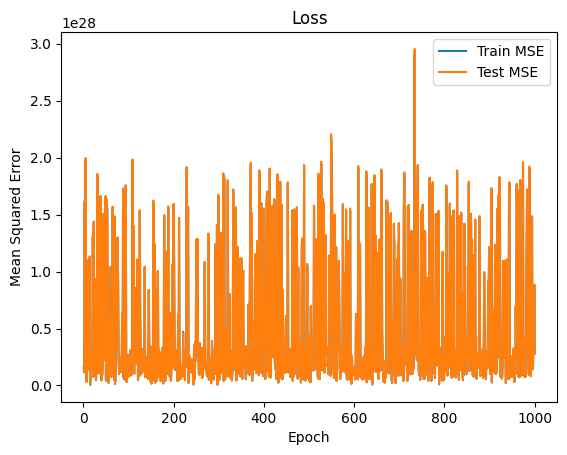

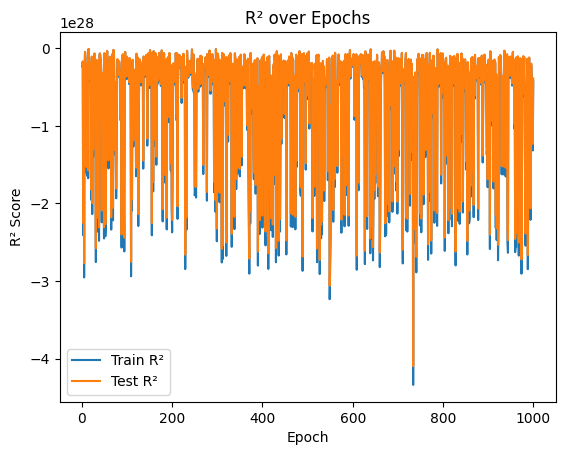

In [87]:
# 4) visualise MSE and R² -----------------------------------------------------
plt.figure(figsize=(20,20))
plt.plot(range(1, n_epochs+1), train_mse, label="Train MSE")
plt.plot(range(1, n_epochs+1), test_mse,  label="Test MSE")
plt.xlabel("Epoch"); plt.ylabel("Mean Squared Error"); plt.title("Loss"); plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, n_epochs+1), train_r2, label="Train R²")
plt.plot(range(1, n_epochs+1), test_r2,  label="Test R²")
plt.xlabel("Epoch"); plt.ylabel("R² Score"); plt.title("R² over Epochs"); plt.legend()
plt.show()